In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv(r'C:\Users\danny\Desktop\DATA 606\news_sentiment_analysis.csv\news_sentiment_analysis.csv')

# Combine Title and Description into a single text column
df['content'] = df['Title'].fillna('') + ' ' + df['Description'].fillna('')

In [ ]:
# Dataset overview
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
display(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Source        3500 non-null   object
 1   Author        2512 non-null   object
 2   Title         3500 non-null   object
 3   Description   3500 non-null   object
 4   URL           3500 non-null   object
 5   Published At  3500 non-null   object
 6   Sentiment     3500 non-null   object
 7   Type          3500 non-null   object
 8   content       3500 non-null   object
dtypes: object(9)
memory usage: 246.2+ KB
None

First 5 rows:


,Source,Author,Title,Description,URL,Published At,Sentiment,Type,content
0,stgnews,Bridger Palmer,Pine View High teacher wins Best in State awar...,"ST. GEORGE — Kaitlyn Larson, a first-year teac...",https://www.stgeorgeutah.com/news/archive/2024...,2024-07-12T23:45:25+00:00,positive,Business,Pine View High teacher wins Best in State awar...
1,Zimbabwe Mail,Staff Reporter,Businesses Face Financial Strain Amid Liquidit...,"Harare, Zimbabwe – Local businesses are grappl...",https://www.thezimbabwemail.com/business/busin...,2024-07-12T22:59:42+00:00,neutral,Business,Businesses Face Financial Strain Amid Liquidit...
2,4-traders,NaN,Musk donates to super pac working to elect Tru...,(marketscreener.com) Billionaire Elon Musk has...,https://www.marketscreener.com/business-leader...,2024-07-12T22:52:55+00:00,positive,Business,Musk donates to super pac working to elect Tru...
3,4-traders,NaN,US FTC issues warning to franchisors over unfa...,(marketscreener.com) A U.S. trade regulator on...,https://www.marketscreener.com/quote/stock/MCD...,2024-07-12T22:41:01+00:00,negative,Business,US FTC issues warning to franchisors over unfa...
4,PLANET,NaN,Rooftop solar's dark side,4.5 million households in the U.S. have solar ...,https://www.npr.org/2024/07/12/1197961036/roof...,2024-07-12T22:28:19+00:00,positive,Business,Rooftop solar's dark side 4.5 million househol...


In [ ]:
# Check for missing values
missing = df.isnull().mean() * 100
print("\nMissing Values (%):")
display(missing)


Missing Values (%):


Source           0.000000
Author          28.228571
Title            0.000000
Description      0.000000
URL              0.000000
Published At     0.000000
Sentiment        0.000000
Type             0.000000
content          0.000000
dtype: float64

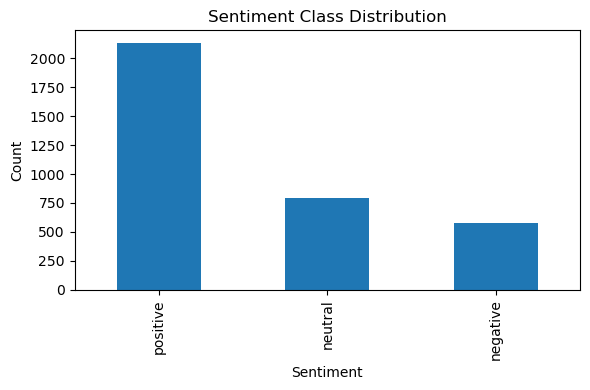

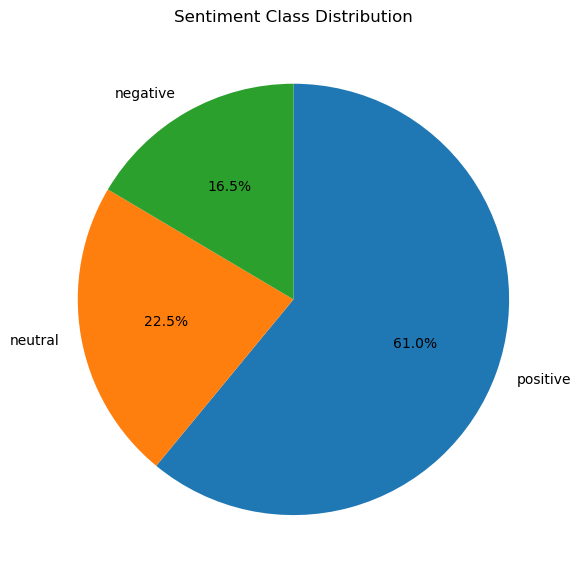

In [ ]:
# Target Distribution
plt.figure(figsize=(6,4))
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Pie Chart for Sentiment Class Distribution
plt.figure(figsize=(6,6))
df['Sentiment'].value_counts().plot(
    kind='pie',
    autopct='%1.1f%%',
    startangle=90,
    counterclock=False
)
plt.title('Sentiment Class Distribution')
plt.ylabel('')
plt.tight_layout()
plt.show()

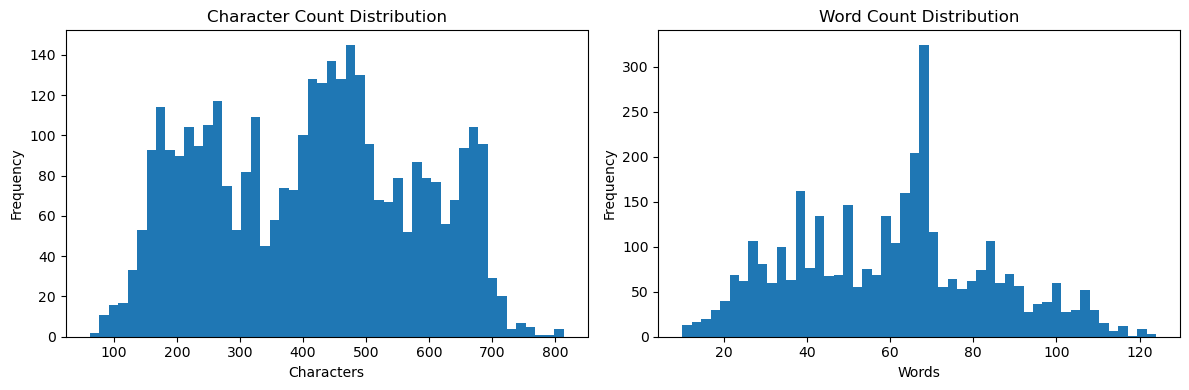

In [ ]:
# Text Length Distribution
df['char_count'] = df['content'].apply(len)
df['word_count'] = df['content'].str.split().apply(len)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['char_count'], bins=50)
plt.title('Character Count Distribution')
plt.xlabel('Characters')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.hist(df['word_count'], bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


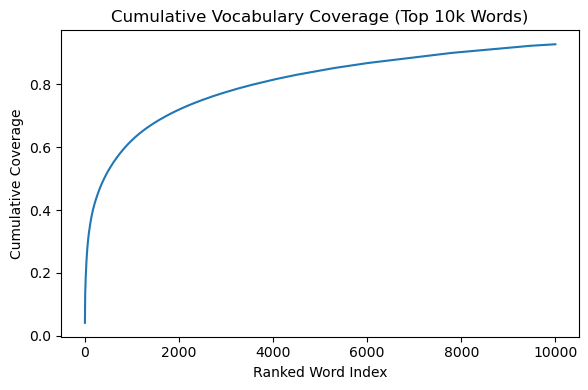

In [ ]:
# Vocabulary Size & Coverage
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(df['content'])
word_counts = np.asarray(X_counts.sum(axis=0)).ravel()
sorted_counts = np.sort(word_counts)[::-1]
cumulative_coverage = np.cumsum(sorted_counts) / sorted_counts.sum()

plt.figure(figsize=(6,4))
plt.plot(cumulative_coverage[:10000])
plt.title('Cumulative Vocabulary Coverage (Top 10k Words)')
plt.xlabel('Ranked Word Index')
plt.ylabel('Cumulative Coverage')
plt.tight_layout()
plt.show()

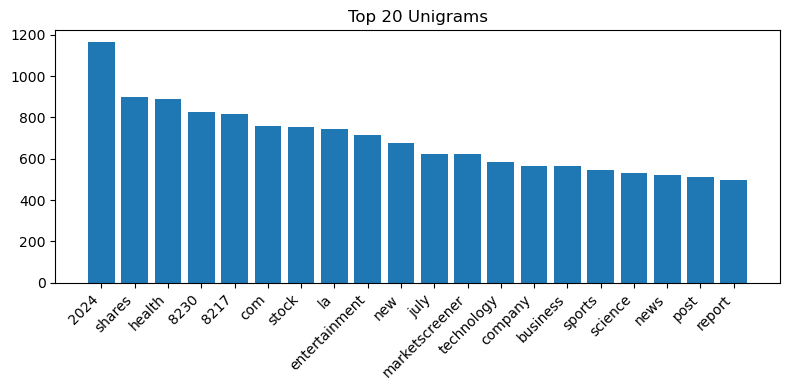

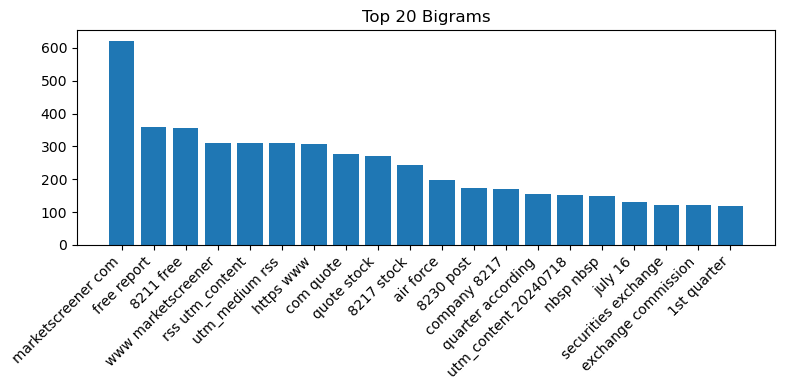

In [ ]:
# Most Frequent Unigrams & Bigrams
unigram_cv = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=20)
bigram_cv = CountVectorizer(ngram_range=(2,2), stop_words='english', max_features=20)

uni_counts = unigram_cv.fit_transform(df['content'])
bi_counts = bigram_cv.fit_transform(df['content'])

def plot_top(cv, counts, title):
    terms = cv.get_feature_names_out()
    freqs = np.asarray(counts.sum(axis=0)).ravel()
    idx = np.argsort(freqs)[::-1]
    plt.figure(figsize=(8,4))
    plt.bar([terms[i] for i in idx], freqs[idx])
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top(unigram_cv, uni_counts, 'Top 20 Unigrams')
plot_top(bigram_cv, bi_counts, 'Top 20 Bigrams')


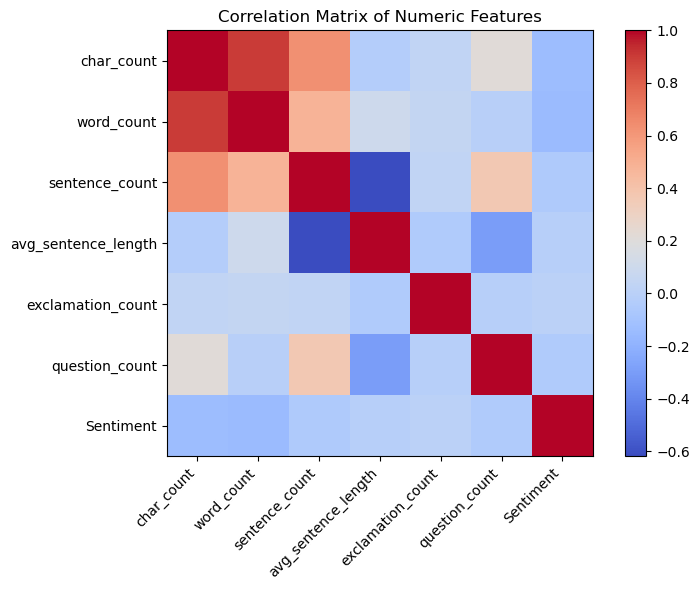

In [ ]:
# Basic Readability & Linguistic Features
df['sentence_count'] = df['content'].str.count(r'[.!?]') + 1
df['avg_sentence_length'] = df['word_count'] / df['sentence_count']
df['exclamation_count'] = df['content'].str.count('!')
df['question_count'] = df['content'].str.count('\?')

numeric_feats = ['char_count', 'word_count', 'sentence_count',
                 'avg_sentence_length', 'exclamation_count', 'question_count']

plt.figure(figsize=(8,6))
corr = df[numeric_feats + ['Sentiment']].apply(lambda x: pd.factorize(x)[0] if x.name=='Sentiment' else x).corr()
plt.imshow(corr, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

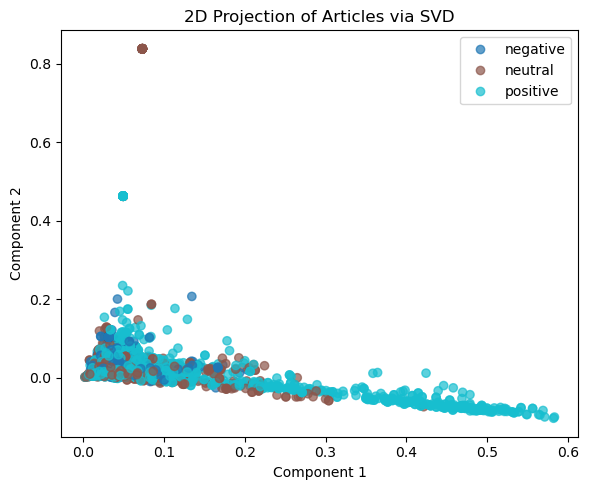

In [ ]:
# TF-IDF + 2D Projection to Explore Class Separation
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = tfidf.fit_transform(df['content'])

svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

le = LabelEncoder()
labels = le.fit_transform(df['Sentiment'])

plt.figure(figsize=(6,5))
scatter = plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap='tab10', alpha=0.7)
handles, _ = scatter.legend_elements()
plt.legend(handles, le.classes_)
plt.title('2D Projection of Articles via SVD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()

In [ ]:
# Temporal and Source Breakdown
df['Published At'] = pd.to_datetime(df['Published At'], errors='coerce')
if df['Published At'].notnull().any():
    weekly = df.set_index('Published At').resample('W')['Sentiment'] \
               .value_counts(normalize=True).unstack()
    print("\nWeekly Sentiment Proportions:")
    display(weekly.head())

print("\nSentiment Counts by Source:")
source_dist = df.groupby(['Source','Sentiment']).size().unstack(fill_value=0)
display(source_dist.head())


Weekly Sentiment Proportions:


Sentiment,negative,neutral,positive
Published At,,,
2024-07-14 00:00:00+00:00,0.155000,0.191429,0.653571
2024-07-21 00:00:00+00:00,0.171429,0.248095,0.580476



Sentiment Counts by Source:


Sentiment,negative,neutral,positive
Source,,,
24 heures,0,3,0
247wallst,0,0,14
4-traders,62,57,192
620wtmj,0,0,5
ABC AU,0,0,3
